
AI-Driven Heat Stress Index Prediction (Mobile-Friendly)
Regression Model - RMSE: 0.2158, R²: 0.9990
Classification Model - Accuracy: 0.9699


Temperature (°C):  13
Humidity (%):  65
Wind Speed (km/h):  5



--- HEAT STRESS PREDICTION ---
Predicted Heat Index: 27.11°C
Risk Level: Low Risk
Advice: Normal activities safe. Stay hydrated.
Risk Probabilities:
  0: 79.6%
  1: 20.4%
  2: 0.0%
  3: 0.0%


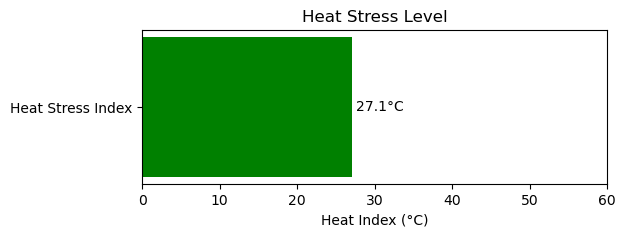

Another prediction? (yes/no):  n


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


class HeatStressPredictor:
    
    def __init__(self):
        self.regression_model = None
        self.classification_model = None
        self.scaler = None
        self.feature_names = ['temp', 'humidity', 'wind_speed']
    
    def compute_heat_index(self, temp_c, rh):

        temp_f = (temp_c * 9/5) + 32
        hi_f = (-42.379 + 2.04901523*temp_f + 10.14333127*rh
                - 0.22475541*temp_f*rh - 0.00683783*temp_f**2
                - 0.05481717*rh**2 + 0.00122874*temp_f**2*rh
                + 0.00085282*temp_f*rh**2 - 0.00000199*temp_f**2*rh**2)
        hi_c = (hi_f - 32) * 5/9
        return hi_c
    
    def create_risk_categories(self, heat_index):
        
        if heat_index < 27:
            return 0  
        elif heat_index < 32:
            return 1  
        elif heat_index < 41:
            return 2  
        elif heat_index < 54:
            return 3  
        else:
            return 4  
    
    def load_and_preprocess_data(self, filepath):
        
        df = pd.read_csv(r"D:\SHUBHRA KANTI BANERJEE\Heat risk index prdiction with ML\kol_wet.csv")  
        
        df = df.rename(columns={
            'Temperature': 'temp',
            'Relative_Humidity': 'humidity',
            'Wind_Speed': 'wind_speed'
        })
      
        df = df.dropna(subset=['temp', 'humidity', 'wind_speed'])
        df = df[df['wind_speed'] > 0] 
      
        df['heat_index'] = df.apply(lambda row: self.compute_heat_index(row['temp'], row['humidity']), axis=1)
    
        df['risk_category'] = df['heat_index'].apply(self.create_risk_categories)
        return df
    
    def train_models(self, df):
        """Train regression and classification models using 3 features"""
        X = df[self.feature_names]
        y_regression = df['heat_index']
        y_classification = df['risk_category']
        

        X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
            X, y_regression, y_classification, test_size=0.2, random_state=42
        )
        

        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        

        self.regression_model = GradientBoostingRegressor(
            n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
        )
        self.regression_model.fit(X_train_scaled, y_reg_train)
        
        y_reg_pred = self.regression_model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
        r2 = r2_score(y_reg_test, y_reg_pred)
        print(f"Regression Model - RMSE: {rmse:.4f}, R²: {r2:.4f}")
        

        self.classification_model = GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
        )
        self.classification_model.fit(X_train_scaled, y_cls_train)
        acc = (self.classification_model.predict(X_test_scaled) == y_cls_test).mean()
        print(f"Classification Model - Accuracy: {acc:.4f}")
    
    def get_risk_info(self, risk_category):
        
        risk_info = {
            0: {'level': 'Low Risk', 'color':'green', 'advice':'Normal activities safe. Stay hydrated.'},
            1: {'level': 'Caution', 'color':'yellow', 'advice':'Fatigue possible. Take breaks.'},
            2: {'level': 'Extreme Caution', 'color':'orange', 'advice':'Limit outdoor exposure.'},
            3: {'level': 'Danger', 'color':'red', 'advice':'Avoid strenuous outdoor activity.'},
            4: {'level': 'Extreme Danger', 'color':'darkred', 'advice':'Stay indoors. Seek medical help if needed.'}
        }
        return risk_info[risk_category]
    
    def predict_from_input(self):
        
        try:
            temp = float(input("Temperature (°C): "))
            humidity = float(input("Humidity (%): "))
            wind_speed = max(0.0, float(input("Wind Speed (km/h): ")) / 3.6)

            
          
            if wind_speed <= 0 or not (0 <= humidity <= 100):
                print("Invalid input! Wind > 0, Humidity 0-100%.")
                return
            
            user_df = pd.DataFrame([[temp, humidity, wind_speed]], columns=self.feature_names)
            X_scaled = self.scaler.transform(user_df)
            
            
            predicted_hi = self.regression_model.predict(X_scaled)[0]
            predicted_risk = self.classification_model.predict(X_scaled)[0]
            probas = self.classification_model.predict_proba(X_scaled)[0]
            
            risk_info = self.get_risk_info(predicted_risk)
            
            # Display
            print("\n--- HEAT STRESS PREDICTION ---")
            print(f"Predicted Heat Index: {predicted_hi:.2f}°C")
            print(f"Risk Level: {risk_info['level']}")
            print(f"Advice: {risk_info['advice']}")
            print("Risk Probabilities:")
            for i, p in enumerate(probas):
                print(f"  {i}: {p*100:.1f}%")
            
            # Visualization
            self.visualize_prediction(predicted_hi, risk_info)
            
        except ValueError:
            print("Enter valid numeric values.")
    
    def visualize_prediction(self, heat_index, risk_info):
        """Simple horizontal bar visualization"""
        plt.figure(figsize=(6,2))
        plt.barh(['Heat Stress Index'], [heat_index], color=risk_info['color'])
        plt.xlim(0, 60)
        plt.xlabel('Heat Index (°C)')
        plt.title('Heat Stress Level')
        plt.text(heat_index + 0.5, 0, f"{heat_index:.1f}°C", va='center')
        plt.show()


def main():
    predictor = HeatStressPredictor()
    print("\nAI-Driven Heat Stress Index Prediction (Mobile-Friendly)")
    
    # Load and preprocess dataset
    try:
        df = predictor.load_and_preprocess_data(r"D:\SHUBHRA KANTI BANERJEE\Heat risk index prdiction with ML\kol_wet.csv")  # replace with your CSV
    except FileNotFoundError:
        print("Dataset 'kol_wet.csv' not found!")
        return
    
    # Train models (3-feature)
    predictor.train_models(df)
    
    # Interactive loop
    while True:
        predictor.predict_from_input()
        again = input("Another prediction? (yes/no): ").strip().lower()
        if again not in ['yes', 'y']:
            break


if __name__ == "__main__":
    main()
